Best Position: [array([0.47036288]), array([0.23759051]), array([0.29204661])]


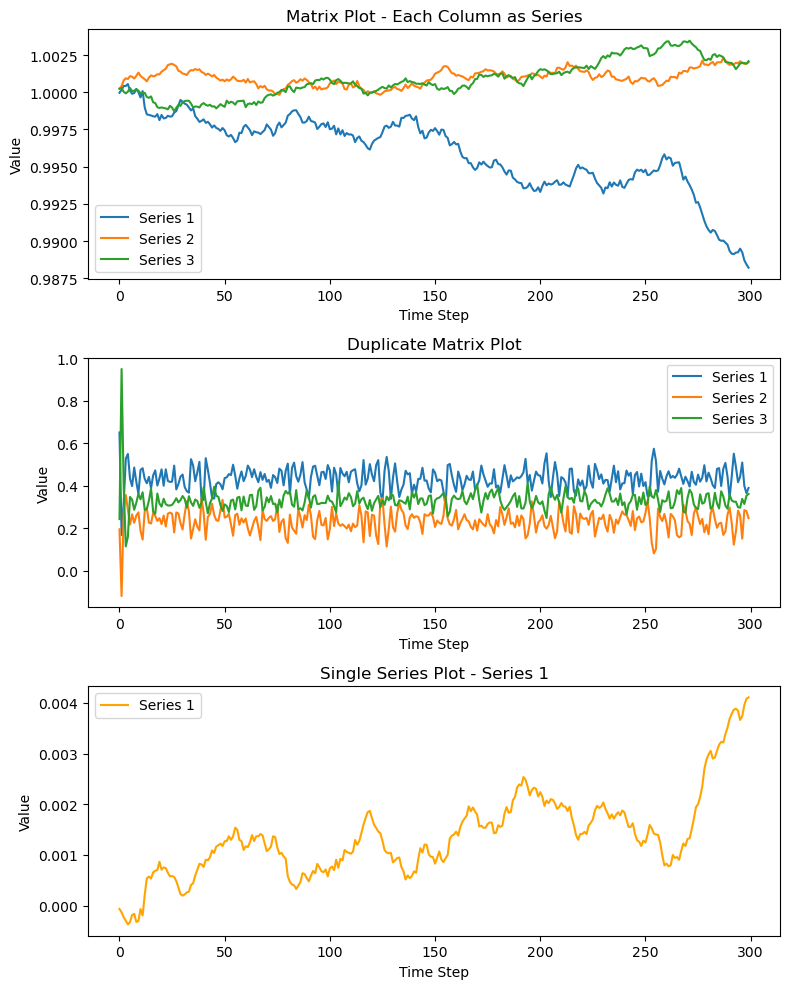

In [37]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


class Particle:
    def __init__(self, dimensions, bounds, params, index, half_life_unit_time):
        self.position = np.random.uniform(bounds[0], bounds[1], dimensions)  
        self.velocity = np.random.uniform(-1, 1, dimensions)  
        self.pbest_position = self.position  
        self.pbest = float('inf')  
        self.params = params
        self.value = 1
        self.alpha = -math.log(2)/half_life_unit_time
        self.index = index
        self.last_return = 0



    def update_personal_best(self, minimize_function,last_return, last_position):
        current = minimize_function(self, last_return, last_position)
        if current < self.pbest:
            self.pbest = current
            self.pbest_position = self.position.copy()

        dt = 0.01 
        val = simulate_Merton_Jump(self.value, self.params)

        #transform into logs
        returnLog = 1- val/self.value

        #calculate weight
        weight = math.exp(self.alpha * dt)

        #calculate average
        self.last_return = returnLog * weight +  self.last_return * (1-weight)
 
        self.value = val

    moving_averages = []



class PSO:
    def __init__(self, n_particles, dimensions, paramss, bounds, w=0.5, c1=1.5, c2=1.5, n_iterations=100):
        self.n_particles = n_particles
        self.dimensions = dimensions
        self.bounds = bounds
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient
        self.n_iterations = n_iterations
        self.swarm = [Particle(dimensions, bounds, paramss[i], i, 0.04 ) for i in range(n_particles)] # half life is set 4 time unit time (0.01)
        self.gbest_position = np.random.uniform(bounds[0], bounds[1], dimensions)  # Global best position
        self.gbest_value = float('inf')  # Global best value (initialized to infinity)
        self.last_return =  [0 for i in range(n_particles)]
        self.last_position =  [1/n_particles for i in range(n_particles)]
        self.portfolio_history = []
        self.portfolio_value = 0
        self.position_history = []
        self.value_history = []



    def optimize(self, objective_function):
        for iteration in range(self.n_iterations):
            temp = []
            temp_pos = []
            temp_val = []

            for particle in self.swarm:
                # Update the personal best of each particle
                particle.update_personal_best(objective_function, self.last_return, self.last_position)
                temp_pos.append(particle.position[0])
                temp.append(particle.last_return)
                temp_val.append(particle.value)
            self.last_return = temp
            self.last_position = temp_pos

            self.value_history.append(temp_val)
            self.position_history.append(temp_pos)

            self.portfolio_value = self.portfolio_value + sum( [self.last_position[i] * self.last_return[i] for i in range(len(self.swarm))])
            total = 0
            for particle in self.swarm:

                if particle.pbest< self.gbest_value :
                    self.gbest_value = particle.pbest
                    self.gbest_position = particle.pbest_position.copy()

                # Update velocity and position
                r1, r2 = np.random.random(self.dimensions), np.random.random(self.dimensions)
                cognitive_velocity = self.c1 * r1 * (particle.pbest_position - particle.position)
                social_velocity = self.c2 * r2 * (self.gbest_position - particle.position)
                particle.velocity = self.w * particle.velocity + cognitive_velocity + social_velocity

                # Update position and apply bounds
                #todo lea block to sum = 1
                particle.position += particle.velocity
                total += particle.position
                #particle.position = np.clip(particle.position, self.bounds[0], self.bounds[1])
            for particle in self.swarm:
                 particle.position = particle.position/total

            self.portfolio_history.append(self.portfolio_value)
        return [particle.position for particle in self.swarm]
    
    def animate(self):
        # Set up plot
        fig, ax = plt.subplots()
        ax.set_xlim(self.bounds[0], self.bounds[1])
        #ax.set_ylim(self.bounds[0], self.bounds[1])

        # Initialize scatter plot with random colors for each particle
        colors = plt.cm.jet(np.linspace(0, 1, self.n_particles))
        scatters = [
            ax.scatter([], [], color=colors[i], s=50, label=f'Particle {i}')
            for i in range(self.n_particles)
        ]
        
        def update(frame):
            # Clear previous positions
            ax.collections.clear()

            # Plot particles for the current frame
            positions = self.position_history[frame]
            for i, scatter in enumerate(scatters):
                scatter.set_offsets(positions[i])
                ax.add_collection(scatter)
            ax.set_title(f"Iteration {frame+1}")

        # Run animation
        anim = FuncAnimation(fig, update, frames=self.n_iterations, repeat=False)
        plt.legend()
        plt.show()

def simulate_Merton_Jump(S, params) :
    mu, sigma, lamb, nu, delta = params
    dt = 0.01 
    dW = math.sqrt(dt) * gaussian()
    diffusion = (mu - 0.5 * sigma ** 2) * dt + sigma * dW

    dN = 1 if random.random() < lamb * dt  else 0
    J = math.exp(nu + delta * gaussian()) if dN == 1 else  1

    return S * math.exp(diffusion) * J
		
def gaussian() :
    u = random.random()
    v = random.random()
    return math.sqrt(-2 * math.log(u)) * math.cos(2 * math.pi * v)
    

def minimize_function(x, value_before,  position):
    # rand for simulated prices 
    temp = 0
    for i in range(len(value_before)):
        if x.index == i :
            temp = temp + x.last_return * x.position
        else :
            temp = temp + value_before[i]*position[i]
    #max of the imidiate return + portfolio 
    return max(value_before) - temp

#portfolio value 


# Parameters
n_particles = 3 # nb of particles
dimensions = 1  # nb of dimensions (e.g., x and y)
bounds = (0, 1)  # Bounds for each dimension
n_iterations = 300  # iterations
S = 1 # Initial FX rate

paramss = [[0,0.0025,0.1,0.0003,0.1],[0.0001,0.0015,0.05,0.001,0.1],[0.0002,0.0015,0.02,0.0005,0.1]]


# Initialize PSO and optimize
pso = PSO(n_particles, dimensions, paramss, bounds, n_iterations=n_iterations)
best_position = pso.optimize(minimize_function)

print("Best Position:", best_position)
#pso.animate()




# Transpose matrix to separate each series as a list
pso_value = np.array(pso.value_history)  
pso_position = np.array(pso.position_history)  
pso_port = np.array(pso.portfolio_history)  
series_count = pso_value.shape[1]

# Set up the plot
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# First Plot: Each column of the matrix as a separate line plot
for i in range(series_count):
    axs[0].plot(pso_value[:,i], label=f"Series {i+1}")
axs[0].set_title("Matrix Plot - Each Column as Series")
axs[0].legend()
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Value")

# Second Plot: Same as the first plot
for i in range(series_count):
    axs[1].plot(pso_position[:,i], label=f"Series {i+1}")
axs[1].set_title("Duplicate Matrix Plot")
axs[1].legend()
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Value")

# Third Plot: Single selected series (e.g., the first column)
selected_series = 0  # Change to any index (0 to series_count - 1) to select a different series
axs[2].plot(pso_port, label=f"Series {selected_series+1}", color="orange")
axs[2].set_title(f"Single Series Plot - Series {selected_series+1}")
axs[2].legend()
axs[2].set_xlabel("Time Step")
axs[2].set_ylabel("Value")

# Display all plots
plt.tight_layout()
plt.show()
